In [1]:
"""
Implementation of a GMM with TensorFlow
Author: Matthew C. McFee
Student #: 1005449631
"""

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# Loading data
data = np.load('data2D.npy')
#data = np.load('data100D.npy')
[num_pts, dim] = np.shape(data)

# For Validation set
is_valid = False
if is_valid:
  valid_batch = int(num_pts / 3.0)
  np.random.seed(45689)
  rnd_idx = np.arange(num_pts)
  np.random.shuffle(rnd_idx)
  val_data = data[rnd_idx[:valid_batch]]
  data = data[rnd_idx[valid_batch:]]

In [3]:
# Helper functions
def reduce_logsumexp(input_tensor, reduction_indices=1, keep_dims=False):
  """Computes the sum of elements across dimensions of a tensor in log domain.

     It uses a similar API to tf.reduce_sum.

  Args:
    input_tensor: The tensor to reduce. Should have numeric type.
    reduction_indices: The dimensions to reduce. 
    keep_dims: If true, retains reduced dimensions with length 1.
  Returns:
    The reduced tensor.
  """
  max_input_tensor1 = tf.compat.v1.reduce_max(
      input_tensor, reduction_indices, keep_dims=keep_dims)
  max_input_tensor2 = max_input_tensor1
  if not keep_dims:
    max_input_tensor2 = tf.expand_dims(max_input_tensor2, reduction_indices)
  return tf.compat.v1.log(
      tf.compat.v1.reduce_sum(
          tf.compat.v1.exp(input_tensor - max_input_tensor2),
          reduction_indices,
          keep_dims=keep_dims)) + max_input_tensor1


def logsoftmax(input_tensor):
  """Computes normal softmax nonlinearity in log domain.

     It can be used to normalize log probability.
     The softmax is always computed along the second dimension of the input Tensor.     

  Args:
    input_tensor: Unnormalized log probability.
  Returns:
    normalized log probability.
  """
  return input_tensor - reduce_logsumexp(input_tensor, reduction_indices=0, keep_dims=True)

In [4]:
from tensorflow.python.ops.math_ops import reduce_logsumexp_v1
# Necessary functions to implement GMM
def distance_func(X, mu):
    """ Inputs:
            X: is an NxD matrix (N observations and D dimensions)
            mu: is an KxD matrix (K means and D dimensions)
        Outputs
            pair_dist: is the pairwise distance matrix (NxK)
    """
    X = tf.expand_dims(X, 1) # Expand dimensions for proper broadcasting
    sub = X - mu
    squared = sub ** 2
    summed = tf.math.reduce_sum(squared, axis=-1)
    sqrted = tf.sqrt(summed)
    pair_dist = sqrted ** 2
    return pair_dist

def log_gauss_pdf(X, mu, sigma):
    """ Inputs: 
            X: N X D
            mu: K X D
            sigma: K X 1

        Outputs:
            log Gaussian PDF (N X K)
    """
    # var = sigma ** 2
    var = sigma
    z = distance_func(X, mu)
    part_1 = -0.5 * z * tf.transpose(1 / var) # See report for derivation
    det = var ** X.shape[1]
    pi_power = (2 * np.pi) ** X.shape[1]
    part_2 = tf.math.log(pi_power * det)
    # part_2 = 1 / part_2
    result = part_1 - tf.transpose(part_2)
    return result


def log_posterior(log_PDF, log_pi):
    """ Inputs:
            log_PDF: log Gaussian PDF N X K
            log_pi: K X 1

        Outputs
            log_post: N X K
    """
    combined = log_PDF  + tf.transpose(log_pi)
    # Note there was an error in tutorial and LSE should be subtracted not added
    result = combined - reduce_logsumexp(combined, reduction_indices=1, keep_dims=True)
    return result

In [5]:
mu = tf.random.normal((5, 1))
log_pi = tf.random.normal((5,1))
# log_pi = logsoftmax(log_pi)
X = tf.random.normal((666, 2))
sigma = tf.random.normal((5, 1))

In [6]:
log_gauss_result =  log_gauss_pdf(X, mu, sigma)
log_pos_result = log_posterior(log_gauss_result, log_pi)

In [7]:
print(log_gauss_result)

tf.Tensor(
[[-4.4239674  -3.0670974  -2.9200082  -0.847214    1.3068042 ]
 [-3.3592649  -2.5741491  -4.4041414  -3.2780535  -2.512891  ]
 [-5.6459913  -2.896493   -1.8169086   0.9944055   4.145089  ]
 ...
 [-5.5385704  -2.8540225  -1.9607239   0.75850844  3.7749596 ]
 [-2.9041266  -3.5260923  -4.0907335  -2.8197823  -1.7050959 ]
 [-6.9857645  -2.2630253  -0.97145724  2.4385264   6.3197427 ]], shape=(666, 5), dtype=float32)


In [8]:
def loss_func(log_PDF, log_pi):
  """
  Simple loss function as shown in PA tutorial.
  """
  combined = log_PDF + tf.transpose(log_pi)
  result = reduce_logsumexp(combined, reduction_indices=1)
  result = -1 * tf.reduce_sum(result)
  return result

In [9]:
def cluster(X, X_val, K, max_iter, tol):
  # Set seed for reproducibility
  tf.random.set_seed(1234)
  # Convert data to tensors
  X = tf.convert_to_tensor(X, dtype=tf.float32)
  X_val = tf.convert_to_tensor(X_val, dtype=tf.float32)
  # Initialize mu
  mu = tf.Variable(tf.random.normal((K, X.shape[1]), dtype=tf.float32))
  # Initialize sigma with sigma = exp(phi) so that the constraint of standard deviation being positive
  # is maintained
  phi = tf.Variable(tf.random.normal((K, 1)), dtype=tf.float32)
  # sigma = tf.math.exp(phi)
  # Initialize psi and then take the softmax to satisfy the constraint of the weights
  psi = tf.Variable(tf.random.normal((K, 1)), dtype=tf.float32)
  # pis = tf.nn.softmax(psi, axis=0)
  # Initialize the training loss lists
  train_loss = []
  val_loss = []
  # Initialize the optimizer 
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.1 , beta_1=0.9 , beta_2=0.99 , epsilon=1e-5)
  val_loss_old = np.inf

  # Perform the forward pass
  for iter in range(max_iter):
    with tf.GradientTape() as tape:
      current_log_PDF = log_gauss_pdf(X, mu, tf.math.exp(phi))
      # current_loss = loss_func(current_log_PDF, tf.math.log(tf.nn.softmax(psi, axis=0)))
      current_loss = loss_func(current_log_PDF, logsoftmax(psi))

    # Append training loss
    train_loss.append(current_loss.numpy())
    # Calculate validation loss and append
    current_log_PDF_val = log_gauss_pdf(X_val, mu, tf.math.exp(phi))
    current_loss_val = loss_func(current_log_PDF_val, logsoftmax(psi))
    val_loss.append(current_loss_val.numpy())

    # Calculate and apply the gradients
    dmu, dphi, dpsi = tape.gradient(current_loss, [mu, phi, psi])
    grads = [dmu, dphi, dpsi]
    optimizer.apply_gradients(zip(grads, [mu, phi, psi]))

  # Assign final clusters
  final_log_PDF = log_gauss_pdf(X, mu, tf.math.exp(phi))
  final_log_PDF_val = log_gauss_pdf(X_val, mu, tf.math.exp(phi))
  train_clusters = log_posterior(final_log_PDF, logsoftmax(psi))
  train_clusters = tf.math.argmax(train_clusters, axis=-1) # argmax not argmin because we want the largest value
  val_clusters = log_posterior(final_log_PDF_val, logsoftmax(psi))
  val_clusters = tf.math.argmax(val_clusters, axis=-1)


  return train_loss, val_loss, train_clusters, val_clusters, mu, phi, psi


In [10]:
losses, val_loss, train_clusters, val_clusters, mu, phi, psi = cluster(data, data, 3, 500, 0.00001)

In [11]:
print(train_clusters)

tf.Tensor([2 2 2 ... 0 1 1], shape=(10000,), dtype=int64)


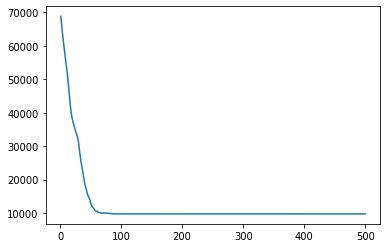

In [12]:
plt.plot(range(1, len(losses) + 1), losses)

In [13]:
np.unique(train_clusters.numpy())

array([0, 1, 2])

In [14]:
# Check the scatter plot
K = 3
# plt.scatter(data[:,0], data[:,1], c=train_clusters)
# Code adapted from https://stackoverflow.com/questions/47006268/matplotlib-scatter-plot-with-color-label-and-legend-specified-by-c-option
for i, g in enumerate(np.unique(train_clusters.numpy())):
    ix = np.where(train_clusters.numpy() == g)
    plt.scatter(data[ix, 0], data[ix, 1], label=g, s=1)
plt.tight_layout()

In [15]:
losses, val_loss, train_clusters, val_clusters, mu, phi, psi = cluster(data, data, 5, 500, 0.00001)

In [16]:
plt.plot(range(1, len(losses) + 1), losses)

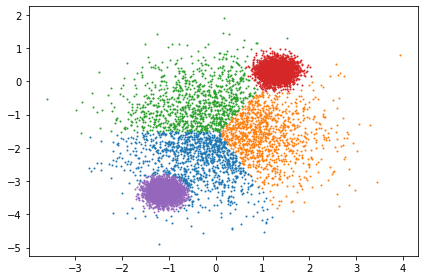

In [17]:
# Check the scatter plot
K = 5
# plt.scatter(data[:,0], data[:,1], c=train_clusters)
# Code adapted from https://stackoverflow.com/questions/47006268/matplotlib-scatter-plot-with-color-label-and-legend-specified-by-c-option
for i, g in enumerate(np.unique(train_clusters.numpy())):
    ix = np.where(train_clusters.numpy() == g)
    plt.scatter(data[ix, 0], data[ix, 1], label=g, s=1)
plt.tight_layout()

In [18]:
# For Validation set
is_valid = True
if is_valid:
  valid_batch = int(num_pts / 3.0)
  np.random.seed(45689)
  rnd_idx = np.arange(num_pts)
  np.random.shuffle(rnd_idx)
  val_data = data[rnd_idx[:valid_batch]]
  data = data[rnd_idx[valid_batch:]]

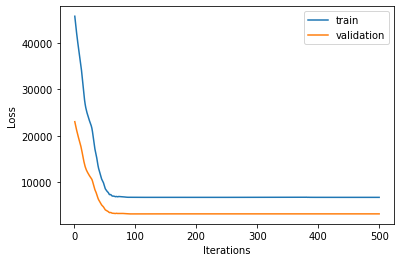

In [19]:
losses, val_losses, train_clusters, val_clusters, mu, phi, psi = cluster(data, val_data, 3, 500, 0.00001)
plt.plot(range(1, len(losses) + 1), losses, label="train")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="validation")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()

In [20]:
np.unique(train_clusters.numpy())

array([0, 1, 2])

In [21]:
var = tf.convert_to_tensor(np.array([1,2,3]))

In [22]:
train_clusters[:50]

<tf.Tensor: shape=(50,), dtype=int64, numpy=
array([0, 0, 0, 0, 1, 1, 2, 1, 1, 0, 0, 2, 0, 2, 1, 0, 2, 1, 2, 1, 1, 1,
       1, 1, 0, 1, 2, 0, 2, 1, 2, 1, 2, 1, 0, 0, 0, 1, 0, 0, 2, 0, 2, 2,
       0, 1, 2, 0, 2, 2])>

In [23]:
losses, val_losses, train_clusters, val_clusters, mu, phi, psi = cluster(data, val_data, 20, 100, 0.00001)
plt.plot(range(1, len(losses) + 1), losses, label="train")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="validation")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()

In [24]:
print(mu)

<tf.Variable 'Variable:0' shape=(20, 2) dtype=float32, numpy=
array([[-0.8842538 , -3.3959582 ],
       [-0.6020143 , -1.1299543 ],
       [ 1.1248626 ,  0.3623569 ],
       [ 0.9825433 , -2.3528292 ],
       [-1.2378103 , -2.8035648 ],
       [-1.0963128 , -3.1342452 ],
       [ 0.8384299 , -1.6101664 ],
       [ 0.19063683, -1.2707932 ],
       [ 1.4459211 ,  0.45120814],
       [-0.942059  , -0.05524899],
       [-1.230844  , -3.4183614 ],
       [-0.6911755 , -1.918125  ],
       [ 0.05533376, -2.0555472 ],
       [ 0.7385927 ,  0.38244364],
       [ 0.91153604, -0.8254316 ],
       [ 0.21298221, -3.0946395 ],
       [ 1.3432173 ,  0.10745196],
       [-1.5505731 , -1.4058851 ],
       [ 1.8946131 , -1.6597797 ],
       [ 0.08691018, -0.50090724]], dtype=float32)>


In [25]:
# Loading data
# data = np.load('data2D.npy')
data = np.load('data100D.npy')
[num_pts, dim] = np.shape(data)

# For Validation set
is_valid = True
if is_valid:
  valid_batch = int(num_pts / 3.0)
  np.random.seed(45689)
  rnd_idx = np.arange(num_pts)
  np.random.shuffle(rnd_idx)
  val_data = data[rnd_idx[:valid_batch]]
  data = data[rnd_idx[valid_batch:]]

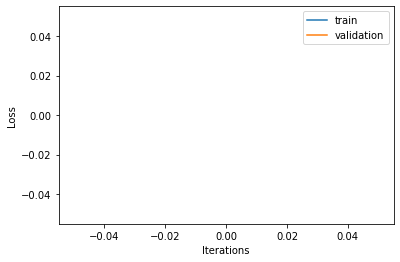

In [26]:
losses, val_losses, train_clusters, val_clusters, mu, phi, psi = cluster(data, val_data, 5, 100, 0.00001)
plt.plot(range(1, len(losses) + 1), losses, label="train")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="validation")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()